<a href= "https://www.snapthat.ai/"> <img src="https://www.snapthat.ai/img/landing/images/logo_h1.png" /></a>

## Training T5 using Native Tensorflow 2

The purpose of this notebook is to demonstrate training using tensorflow 2 and keras. This notebook includes tf Data pipelines for build any other NLP task in a text to text fashion. Anyone can adapt the data pipeline to thier own datasets. Uses the efficient [Datasets](https://github.com/huggingface/datasets) from 🤗 as source for training.
#### Features
- Train TF T5 on SQUAD questioning and answering
- Train T5 using keras trainer fucntion
- tf.Data pipeline
- [Datasets from 🤗](https://github.com/huggingface/datasets) as source
- Log metrics using tensorboard
- Profile your experiment with the brand new tensorflow profiler !!

### Installation

In [ ]:
from IPython.display import clear_output

!pip install transformers==3.3.1
# !pip install transformers
!pip install datasets==1.0.2

# clear_output()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-3.3.1-py3-none-any.whl (1.1 MB)
  Using cached tokenizers-0.8.1rc2.tar.gz (97 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/

In [ ]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import transformers
import datasets
from transformers import AutoTokenizer, TFT5ForConditionalGeneration
import datetime
import os
%load_ext tensorboard

In [ ]:
tf_version = tf.__version__
print("Tensorflow: ", tf_version)
print("Transformers: ", transformers.__version__)
print("Datasets: ", datasets.__version__)

tf_version_split = tf_version.split('.')
assert int(tf_version_split[0])==2 and int(tf_version_split[-2])>=3, f"Tensorflow version should be '2.3+,x', given {tf_version}"


Tensorflow:  2.12.0
Transformers:  4.30.2
Datasets:  1.0.2


In [ ]:
!mkdir data
!ls -la

mkdir: cannot create directory ‘data’: File exists
total 20
drwxr-xr-x 1 root root 4096 Jun 22 02:08 .
drwxr-xr-x 1 root root 4096 Jun 22 02:05 ..
drwxr-xr-x 4 root root 4096 Jun 20 13:38 .config
drwxr-xr-x 3 root root 4096 Jun 22 02:21 data
drwxr-xr-x 1 root root 4096 Jun 20 13:39 sample_data


In [ ]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

### Defining the Model

To add a learning rate decay in the optimizer, you can modify your code as follows:

```python
import tensorflow as tf

class SnapthatT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir=None, initial_lr=0.01, decay_rate=0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.initial_lr)
    
    def get_current_lr(self):
        step = self.optimizer.iterations
        return self.initial_lr * tf.math.pow(self.decay_rate, step)

    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.get_current_lr()
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}
```

In this modified code:

1. The `initial_lr` and `decay_rate` arguments are added to the `__init__` method. These parameters allow you to specify the initial learning rate and the decay rate for the optimizer.
2. A new method `get_current_lr` is defined to calculate the current learning rate based on the number of optimizer iterations. It uses the formula `initial_lr * decay_rate^step`, where `step` is the number of iterations.
3. In the `train_step` method, `self.optimizer.apply_gradients` is still used to update the model's trainable variables. The current learning rate is obtained by calling `self.get_current_lr()`.
4. The `lr` value is added to the `metrics` dictionary for tracking purposes.

Make sure to adjust the `initial_lr` and `decay_rate` values according to your desired learning rate decay strategy.

In [ ]:
class SnapthatT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss')

    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)

            grads = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        # lr = self.optimizer._decayed_lr(tf.float32)
        lr = 0.01

        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})

        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]

        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}


### The Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### Preparing the Data

In [ ]:
train_dataset = load_dataset('squad', split='train')
valid_dataset = load_dataset('squad', split='validation')

train_dataset.features

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41)
Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41)


{'id': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}

In [ ]:
data = next(iter(train_dataset))
print("Example data from the dataset: \n", data)

Example data from the dataset: 
 {'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}, 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'id': '5733be284776f41900661182', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'title': 'University_of_Notre_Dame'}


### Training Parameters

In [ ]:
warmup_steps = 1e4
batch_size = 4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000
ntrain = len(train_dataset)
nvalid = len(valid_dataset)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

Total Steps:  21900
Total Validation Steps:  2643


### Defining the data pipeline

In [ ]:
def encode(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):

    context = example['context']
    question = example['question']
    answer = example['answers']['text']

    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)} </s>"

    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus} </s>"

    encoder_inputs = tokenizer(question_plus, truncation=True,
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)

    decoder_inputs = tokenizer(answer_plus, truncation=True,
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)

    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]

    outputs = {'input_ids':input_ids, 'attention_mask': input_attention,
               'labels':target_ids, 'decoder_attention_mask':target_attention}
    return outputs



In [ ]:
# !pip install dill==0.3.5.1

In [ ]:
train_ds = train_dataset.map(encode)
valid_ds = valid_dataset.map(encode)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/87599 [00:00<?, ?ex/s]

  0%|          | 0/10570 [00:00<?, ?ex/s]

In [ ]:
ex = next(iter(train_ds))
print("Example data from the mapped dataset: \n", ex)

Example data from the mapped dataset: 
 {'attention_mask': <tf.Tensor: shape=(250,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])>, 'decoder_attention_mask': <tf.Tensor: shape=(54,), dtype=i

In [ ]:
def to_tf_dataset(dataset):
  columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
  dataset.set_format(type='tensorflow', columns=columns)
  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32,
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]),
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds

In [ ]:
tf_train_ds = to_tf_dataset(train_ds)
tf_valid_ds = to_tf_dataset(valid_ds)

In [ ]:
def create_dataset(dataset, cache_path=None, batch_size=4,
                   buffer_size= 1000, shuffling=True):
    if cache_path is not None:
        dataset = dataset.cache(cache_path)
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
tf_train_ds = create_dataset(tf_train_ds, batch_size=batch_size,
                         shuffling=True, cache_path = None)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size,
                         shuffling=False, cache_path = None)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=1e4):
    super().__init__()

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    m = tf.maximum(self.warmup_steps, step)
    m = tf.cast(m, tf.float32)
    lr = tf.math.rsqrt(m)

    return lr


Text(0, 0.5, 'Learning rate')

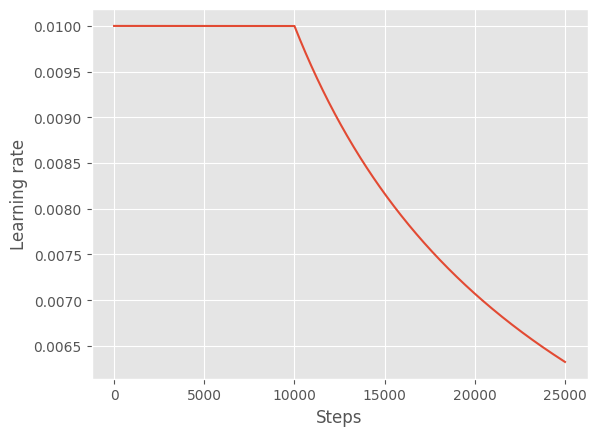

In [ ]:
plt.style.use('ggplot')
schedule = CustomSchedule()
plt.plot(schedule(tf.range(25000, dtype=tf.float32)))
plt.xlabel("Steps")
plt.ylabel("Learning rate")

### Callbacks and Metrics

In [ ]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback]
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ]

### Training

In [ ]:
# learning_rate = CustomSchedule()
learning_rate = 0.001  # Instead set a static learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [ ]:
model = SnapthatT5.from_pretrained("t5-base")

All PyTorch model weights were used when initializing SnapthatT5.

Some weights or buffers of the TF 2.0 model SnapthatT5 were not initialized from the PyTorch model and are newly initialized: ['total', 'count']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.compile(optimizer=optimizer, metrics=metrics)

In [ ]:
# %tensorboard --logdir ./data/experiments/t5/logs

In [ ]:
epochs_done = 0
model.fit(tf_train_ds, epochs=5, steps_per_epoch=steps, callbacks=callbacks,
          validation_data=tf_valid_ds, validation_steps=valid_steps, initial_epoch=epochs_done)

Epoch 1/5
 1192/21900 [>.............................] - ETA: 2:11:54 - accuracy: 0.9924 - loss: 0.1070 - lr: 0.0100

In [ ]:
# model.save_pretrained(save_path)

### Lets test our model!!

In [ ]:
context = """We went on a trip to Europe. We had our breakfast at 7 am in the morning at \
the nearby coffee shop. Wore a dark blue over coat for our first visit to Louvre Museum \
to experience history and art."""

question = "At what time did we had breakfast?"
print(context)
print(question)

In [ ]:
input_text =  f"answer_me: {question} context: {context} </s>"
encoded_query = tokenizer(input_text,
                         return_tensors='tf', pad_to_max_length=True, truncation=True, max_length=encoder_max_len)
input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]
generated_answer = model.generate(input_ids, attention_mask=attention_mask,
                                 max_length=decoder_max_len, top_p=0.95, top_k=50, repetition_penalty=2)
decoded_answer = tokenizer.decode(generated_answer.numpy()[0])
print("Answer: ", decoded_answer)